In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Preparing Data**

In [9]:
df = pd.read_csv(
    '/content/drive/MyDrive/Dataset/london-bike-sharing-dataset/london_merged.csv',
    parse_dates=['timestamp'], 
    index_col = "timestamp"
)
df

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0


In [10]:
df.dtypes

cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

**Checking for Stationarity**

A stationary series is one in which the properties – mean, variance, and covariance – do not vary with time.
<br>
For a series to be stationary, the eigenvalues should be less than one in modulus. 
<br>
The Johansen test can be used to check for cointegration between a maximum of 12 time series.
<br>

In [12]:
#checking stationarity
import pandas.util.testing as tm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johan_test_temp = df
coint_johansen(johan_test_temp,-1,1).eig

array([2.61219379e-01, 1.31970167e-01, 5.22046139e-02, 4.19830465e-02,
       2.10126207e-02, 1.75450605e-02, 1.36518877e-02, 6.26085775e-04,
       7.56291478e-05])

All eigenvalues are under one, implying that all time series under test are stationary.

**Exploring Data**

*plot the cnt distribution*

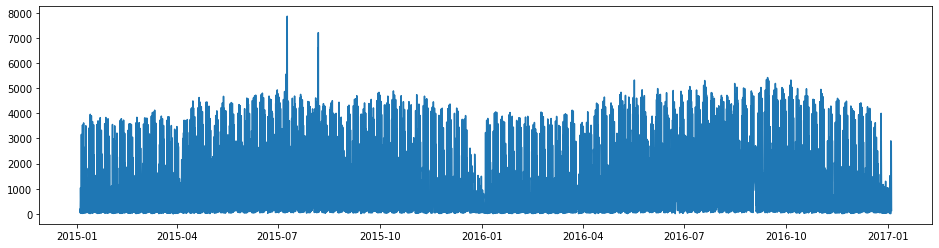

In [13]:
plt.figure(figsize = (16,4))
plt.plot(df.index, df["cnt"]);

Inference: 
<br>
It looks like the demand is evenly distributed throughout the entire period.

Let us examine if there are any seasonal changes in the demand distribution.

In [15]:
# create indexes
df['hour'] = df.index.hour
df['month'] = df.index.month
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month
timestamp,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,1


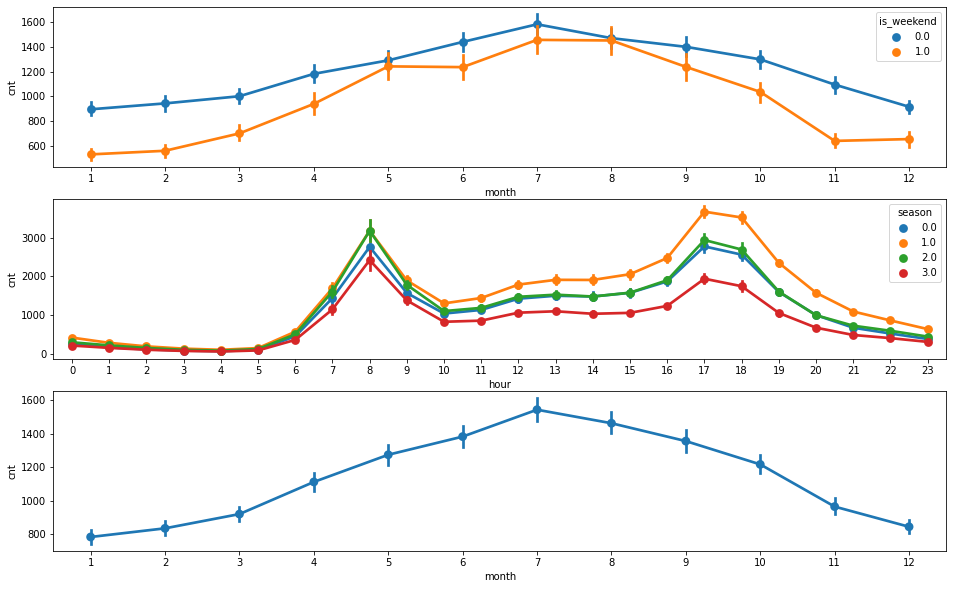

In [16]:
fig,(ax1, ax2, ax3)= plt.subplots(nrows = 3)

fig.set_size_inches(16, 10)

sns.pointplot(data = df, x = 'month', y = 'cnt', hue = 'is_weekend', ax = ax1)
sns.pointplot(data = df, x = 'hour', y = 'cnt', hue = 'season', ax = ax2);
sns.pointplot(data = df, x = 'month', y = 'cnt', ax = ax3)

**Preparing Data**

In [17]:
# scaling numeric columns
scaler = sklearn.preprocessing.MinMaxScaler()

df['t1'] = scaler.fit_transform(df['t1'].values.reshape(-1,1))
df['t2'] = scaler.fit_transform(df['t2'].values.reshape(-1,1))
df['hum'] = scaler.fit_transform(df['hum'].values.reshape(-1,1))
df['wind_speed'] = scaler.fit_transform(df['wind_speed'].values.reshape(-1,1))
df['cnt'] = scaler.fit_transform(df['cnt'].values.reshape(-1,1))

In [18]:
# use 90% for training
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size],df.iloc[train_size:len(df)]

In [19]:
def create_dataset(X, y, time_steps = 1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i:(i + time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(ys)

In [20]:
time_steps = 10
X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

In [21]:
batch_size = 256
buffer_size = 1000

In [22]:
train_data = tf.data.Dataset.from_tensor_slices((X_train , y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
test_data = tf.data.Dataset.from_tensor_slices((X_test , y_test))
test_data = test_data.batch(batch_size).repeat()

**Creating Model**

In [23]:
simple_lstm_model = tf.keras.models.Sequential(
    [
     tf.keras.layers.LSTM(8, input_shape = X_train.shape[-2:]),
     tf.keras.layers.Dense(1)
     ]
)
simple_lstm_model.compile(optimizer = 'adam', loss = 'mae')

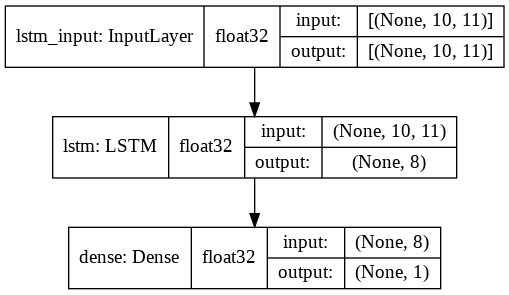

In [25]:
tf.keras.utils.plot_model(simple_lstm_model, show_shapes=True, show_dtype=True)

**Training**

In [26]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [27]:
history = simple_lstm_model.fit(
    train_data,
    epochs = EPOCHS,
    steps_per_epoch = EVALUATION_INTERVAL,
    validation_data = test_data,
    validation_steps = 50
)

Epoch 1/10
200/200 [==============================] - 4s 10ms/step - loss: 0.3018 - val_loss: 0.1220
Epoch 2/10
200/200 [==============================] - 2s 7ms/step - loss: 0.0862 - val_loss: 0.0733
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0671 - val_loss: 0.0569
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0589 - val_loss: 0.0538
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0534 - val_loss: 0.0554
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0499 - val_loss: 0.0495
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0469 - val_loss: 0.0444
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0440 - val_loss: 0.0426
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0414 - val_loss: 0.0396
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0386 - val_loss: 0.039

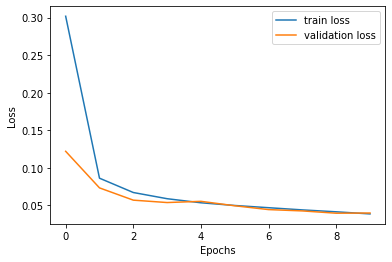

In [28]:
# plot losses
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

**Evaluation**

In [31]:
X_test,y_test = create_dataset(df,df.cnt,10)
y_pred = simple_lstm_model.predict(X_test)

In [32]:
def create_time_steps(length):
  return list(range(-length, 0))

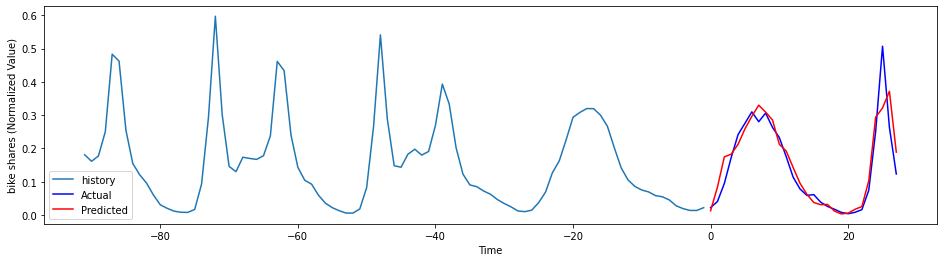

In [42]:
plt.figure(figsize = (16,4))

num_in = create_time_steps(91)
num_out = 28

plt.plot(num_in, y_train[15571:],label = 'history')
plt.plot(np.arange(num_out), y_test[15661:15689], 'b',label='Actual')
plt.plot(np.arange(num_out), y_pred[15661:15689], 'r',label = 'Predicted')

plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()

**Predicting Future Point**

In [44]:
y_pred = simple_lstm_model.predict(X_test[-1:])
y_pred

array([[0.04635212]], dtype=float32)

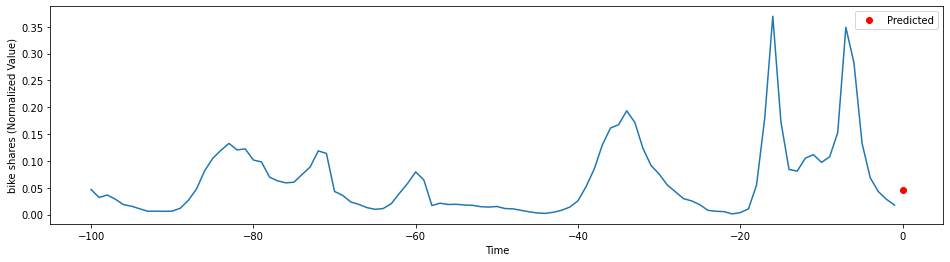

In [45]:
# plot prediction
plt.figure(figsize = (16,4))

num_in = create_time_steps(100)
num_out = 1

plt.plot(num_in,y_test[-100:])
plt.plot(np.arange(num_out),y_pred, 'ro',label = 'Predicted')

plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()

**Predicting Range of Data Points**

In [47]:
df2 = df['2017-01-03 14:00:00':'2017-01-03 23:00:00']
df2

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month
timestamp,,,,,,,,,,,
2017-01-03 14:00:00,0.097328,0.211268,0.2000,0.666667,0.389381,3.0,0.0,0.0,3.0,14,1
2017-01-03 15:00:00,0.107506,0.211268,0.2000,0.635220,0.477876,4.0,0.0,0.0,3.0,15,1
2017-01-03 16:00:00,0.152799,0.211268,0.2000,0.635220,0.460177,4.0,0.0,0.0,3.0,16,1
2017-01-03 17:00:00,0.348855,0.211268,0.2000,0.666667,0.371681,3.0,0.0,0.0,3.0,17,1
2017-01-03 18:00:00,0.282443,0.183099,0.1750,0.761006,0.389381,2.0,0.0,0.0,3.0,18,1
2017-01-03 19:00:00,0.132570,0.183099,0.1750,0.761006,0.336283,3.0,0.0,0.0,3.0,19,1
2017-01-03 20:00:00,0.068830,0.183099,0.1750,0.761006,0.371681,4.0,0.0,0.0,3.0,20,1
2017-01-03 21:00:00,0.042875,0.197183,0.1875,0.729560,0.424779,4.0,0.0,0.0,3.0,21,1
2017-01-03 22:00:00,0.028499,0.197183,0.1875,0.698113,0.407080,4.0,0.0,0.0,3.0,22,1


In [48]:
df1 = df['2016-01-04 00:00:00':'2016-01-06 23:00:00']
df1

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month
timestamp,,,,,,,,,,,
2016-01-04 00:00:00,0.010305,0.267606,0.3000,0.836478,0.176991,1.0,0.0,0.0,3.0,0,1
2016-01-04 01:00:00,0.007506,0.267606,0.3000,0.805031,0.230088,1.0,0.0,0.0,3.0,1,1
2016-01-04 02:00:00,0.004326,0.267606,0.3000,0.773585,0.194690,1.0,0.0,0.0,3.0,2,1
2016-01-04 03:00:00,0.003181,0.267606,0.3000,0.773585,0.212389,2.0,0.0,0.0,3.0,3,1
2016-01-04 04:00:00,0.004707,0.267606,0.3000,0.773585,0.176991,2.0,0.0,0.0,3.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-01-06 19:00:00,0.191476,0.239437,0.3000,0.874214,0.123894,2.0,0.0,0.0,3.0,19,1
2016-01-06 20:00:00,0.106107,0.239437,0.3000,0.836478,0.115044,2.0,0.0,0.0,3.0,20,1
2016-01-06 21:00:00,0.069720,0.211268,0.2625,0.911950,0.115044,2.0,0.0,0.0,3.0,21,1


In [50]:
df1['cnt'] = 0
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month
timestamp,,,,,,,,,,,
2016-01-04 00:00:00,0,0.267606,0.3000,0.836478,0.176991,1.0,0.0,0.0,3.0,0,1
2016-01-04 01:00:00,0,0.267606,0.3000,0.805031,0.230088,1.0,0.0,0.0,3.0,1,1
2016-01-04 02:00:00,0,0.267606,0.3000,0.773585,0.194690,1.0,0.0,0.0,3.0,2,1
2016-01-04 03:00:00,0,0.267606,0.3000,0.773585,0.212389,2.0,0.0,0.0,3.0,3,1
2016-01-04 04:00:00,0,0.267606,0.3000,0.773585,0.176991,2.0,0.0,0.0,3.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-01-06 19:00:00,0,0.239437,0.3000,0.874214,0.123894,2.0,0.0,0.0,3.0,19,1
2016-01-06 20:00:00,0,0.239437,0.3000,0.836478,0.115044,2.0,0.0,0.0,3.0,20,1
2016-01-06 21:00:00,0,0.211268,0.2625,0.911950,0.115044,2.0,0.0,0.0,3.0,21,1


In [52]:
df_future = df2.append(df1, sort = False)

In [53]:
df_future

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month
timestamp,,,,,,,,,,,
2017-01-03 14:00:00,0.097328,0.211268,0.2000,0.666667,0.389381,3.0,0.0,0.0,3.0,14,1
2017-01-03 15:00:00,0.107506,0.211268,0.2000,0.635220,0.477876,4.0,0.0,0.0,3.0,15,1
2017-01-03 16:00:00,0.152799,0.211268,0.2000,0.635220,0.460177,4.0,0.0,0.0,3.0,16,1
2017-01-03 17:00:00,0.348855,0.211268,0.2000,0.666667,0.371681,3.0,0.0,0.0,3.0,17,1
2017-01-03 18:00:00,0.282443,0.183099,0.1750,0.761006,0.389381,2.0,0.0,0.0,3.0,18,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-01-06 19:00:00,0.000000,0.239437,0.3000,0.874214,0.123894,2.0,0.0,0.0,3.0,19,1
2016-01-06 20:00:00,0.000000,0.239437,0.3000,0.836478,0.115044,2.0,0.0,0.0,3.0,20,1
2016-01-06 21:00:00,0.000000,0.211268,0.2625,0.911950,0.115044,2.0,0.0,0.0,3.0,21,1


In [54]:
predictions = []

# make prediction in a loop every time adding the last prediction
for i in range(50):
  X_f, y_f = create_dataset(df_future, df_future.cnt, time_steps)
  y_pred = simple_lstm_model.predict(X_f[i:i+1])
  df_future['cnt'][i+10] = y_pred
  predictions.append(float(y_pred[0][0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


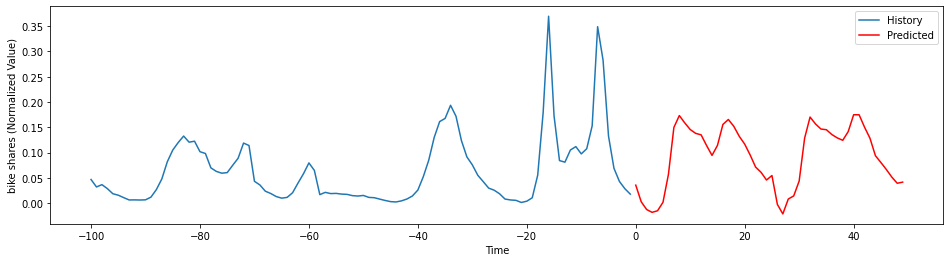

In [55]:
plt.figure(figsize = (16,4))

num_in = create_time_steps(100)
num_out = 50

plt.plot(num_in,y_test[-100:],label = 'History')
plt.plot(np.arange(num_out), predictions, 'r',label = 'Predicted')

plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()

---